## Stacking Ensemble Model

**TLDR**: Individually, the models LSTM, SVR, and RNN EPAG have the following performance (MAE / MSE):

- LSTM: 0.399 / 0.379
- SRV: 0.375 / 0.288
- RNN EPAG: 0.485 / 0.480

The naive model, i.e. the simple average across all models per timestep, fails to outperform either of the isolated models.  

Expanding on this, a Random Forest Regressor (with and without BF15_1h_lag0 as exogenous variable) has been trained. The results are as follows (MAE / MSE):

- RFR with BF15_1h_lag0: 0.308 / 0.297
- RFR w/out BF15 variables: 0.309 / 0.304

Additionally, a Linear Regression was performed to compare the RFR output. Although it performs better than the individual models, it fails to outperform the Random Forest Classifier:

- Linear Regression with BF15_1h_lag0: 0.329 / 0.278

In [1]:
import pandas as pd
import numpy as np

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, inverse_transform_minmax, split_dataframe
from models.deeplearner import DeepLearner

from solutil import evaluations as ev
from solutil import feature_selection as fs

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid

### Data Import

In [2]:
# CSV Import YPred
df_lstm = pd.read_csv('experiments/stacking_data/ypred_lstm.csv', index_col=0)
df_svr = pd.read_csv('experiments/stacking_data/ypred_svr.csv', index_col=0)
df_bm = pd.read_csv('experiments/stacking_data/ypred_benchmark_4h.csv', index_col=0)

In [3]:
# CSV Import Features
df_features = pd.read_csv('experiments/stacking_data/features_lstm.csv', index_col=0)
df_solofeat = df_features.copy().drop(columns=['temp_1h_lag1', 'glob_1h_lag2', 'glob_1h_lag3',
                                               'rain_1h_lag1', 'schmelz_1h_lag1'])

In [4]:
# Dataframe Stacking & Handling
df_step1 = df_lstm.merge(right=df_svr, how='outer', left_index=True, right_index=True)
df_inlet1 = df_step1.merge(right=df_bm, how='inner', left_index=True, right_index=True)
df_inlet1.drop(columns=['ytest_svr', 'act_inlet1', 'act_inlet2', 'pred_inlet2'], inplace=True)
df_inlet1.dropna(inplace=True)
df_inlet1.rename(columns={'pred_inlet1':'ypred_rnn_inl1'}, inplace=True)

In [5]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1
2023-07-10 08:00:00+01:00,0.628402,0.637005,0.875669,0.441813
2023-07-10 12:00:00+01:00,0.833971,1.275235,0.914186,0.548256
2023-07-10 16:00:00+01:00,0.882431,1.031926,0.967088,0.491934
2023-07-10 20:00:00+01:00,0.819062,0.876131,1.041211,0.421105
2023-07-11 00:00:00+01:00,0.731699,0.749766,1.020711,0.568631
...,...,...,...,...
2024-06-30 08:00:00+01:00,4.170260,4.200000,4.290542,3.719067
2024-06-30 12:00:00+01:00,4.173786,4.200000,3.868063,3.763970
2024-06-30 16:00:00+01:00,4.169545,4.200000,3.867082,3.711948
2024-06-30 20:00:00+01:00,4.158882,4.200000,3.829652,3.754528


### Feature Analysis

C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascie

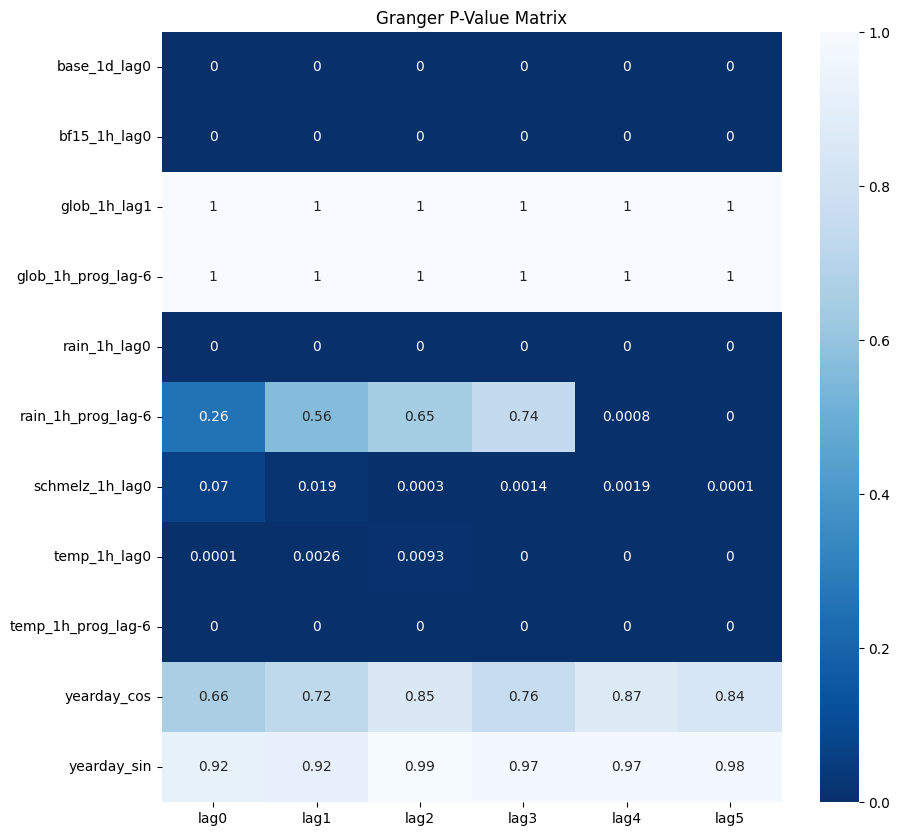

In [6]:
# Calculate Granger Causality Tests
granger = fs.granger_causality_test(df=df_solofeat, target_var='base_lag0', annot=True)

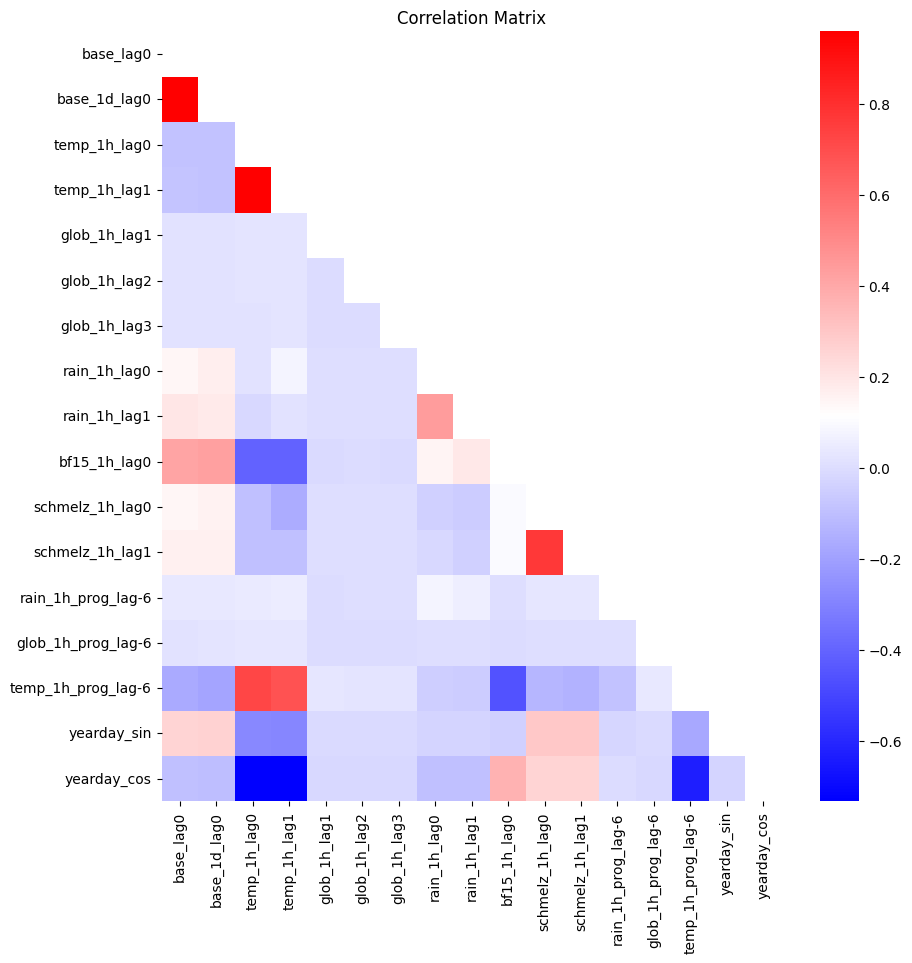

In [7]:
# Calculate Correlogram
corr_matrix = fs.correlation_matrix(df_features, method='pearson')

### Sample Preparation for ML Models

In [8]:
# Add most relevant feature
df_inlet1['bf15_1h_lag0'] = df_features['bf15_1h_lag0']

In [9]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1,bf15_1h_lag0
2023-07-10 08:00:00+01:00,0.628402,0.637005,0.875669,0.441813,0.675500
2023-07-10 12:00:00+01:00,0.833971,1.275235,0.914186,0.548256,0.650167
2023-07-10 16:00:00+01:00,0.882431,1.031926,0.967088,0.491934,0.636292
2023-07-10 20:00:00+01:00,0.819062,0.876131,1.041211,0.421105,0.647354
2023-07-11 00:00:00+01:00,0.731699,0.749766,1.020711,0.568631,0.650875
...,...,...,...,...,...
2024-06-30 08:00:00+01:00,4.170260,4.200000,4.290542,3.719067,NaN
2024-06-30 12:00:00+01:00,4.173786,4.200000,3.868063,3.763970,NaN
2024-06-30 16:00:00+01:00,4.169545,4.200000,3.867082,3.711948,NaN
2024-06-30 20:00:00+01:00,4.158882,4.200000,3.829652,3.754528,NaN


In [10]:
# Min Max Scaling
df_inlet1_scaled = scale_with_minmax(df_features=df_inlet1, str_model='inlet1_ens')

In [11]:
# Split dataframe
x_train, x_test, y_train, y_test = split_dataframe(df_features=df_inlet1_scaled, target_var='ytest')

### Ensemble Model Construction

#### Isolated Predictions

In [12]:
# Get Date Limits for Test Set 
start_date = y_test.index[0]
end_date = y_test.index[-1]

In [13]:
df_inlet_short = df_inlet1.loc[(df_inlet1.index >= start_date) & (df_inlet1.index <= end_date)]

**LSTM**

In [14]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_lstm'])

{'mae': 0.37057932915094777,
 'mse': 0.37938052247460263,
 'rmse': 0.6159387327280227,
 'mape': 36271933955344.54,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

**SVR**

In [15]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_svr'])

{'mae': 0.3963504400610816,
 'mse': 0.30516203708158873,
 'rmse': 0.5524147328607273,
 'mape': 26324317355953.215,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

**RNN EPAG**

In [16]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_rnn_inl1'])

{'mae': 0.4916548151605076,
 'mse': 0.48609836149385083,
 'rmse': 0.6972075454940594,
 'mape': 47194900988663.164,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Naive Model

In [17]:
x_test_naive = x_test.drop(columns=['bf15_1h_lag0'])

In [18]:
ypred_naive = x_test_naive.mean(axis=1)

In [19]:
# Rescale predictions
y_pred_naive_rescaled = inverse_transform_minmax(df_scaled=ypred_naive, str_model='inlet1_ens', attributes='ytest')
y_test_rescaled = inverse_transform_minmax(df_scaled=y_test, str_model='inlet1_ens', attributes='ytest')

In [20]:
ev.get_eval_metrics(y_test_rescaled, y_pred_naive_rescaled)

{'mae': 0.5363602442080181,
 'mse': 0.42204144352710304,
 'rmse': 0.649647168490022,
 'mape': 33754633090608.69,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Random Forest Regressor with BF15_1h_lag0

**Grid Search**

In [21]:
# Instantiate RFR
grid_forest = RandomForestRegressor(n_jobs=-1)

In [22]:
# Define Parameter Grid
hyperparams = {
   'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 8, 16, 32, 64],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 8, 16]
}

param_grid = ParameterGrid(hyperparams)

In [23]:
# Instantiate Grid Search Object
rfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [24]:
rfr_gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
# Output Results
print(f"Best Parameters: {rfr_gridsearch.best_params_}")
print(f"Best Score: {rfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': 64, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 100}
Best Score: -0.012974167984919122


- Best Parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
- Best Score: -0.012115434320588073

**Random Forest Model**

In [26]:
# Define hyperparameters
best_params = {'max_depth': 32, 
               'min_samples_leaf': 8, 
               'min_samples_split': 8, 
               'n_estimators': 100}

In [27]:
# Parameterize model
forest = RandomForestRegressor(**rfr_gridsearch.best_params_)

In [28]:
# Train model
trained_forest = forest.fit(x_train, y_train)

In [29]:
# Predict inlet1
ypred_rfr = trained_forest.predict(x_test)

In [30]:
# Rescale predictions
y_pred_rfr_rescaled = inverse_transform_minmax(df_scaled=ypred_rfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

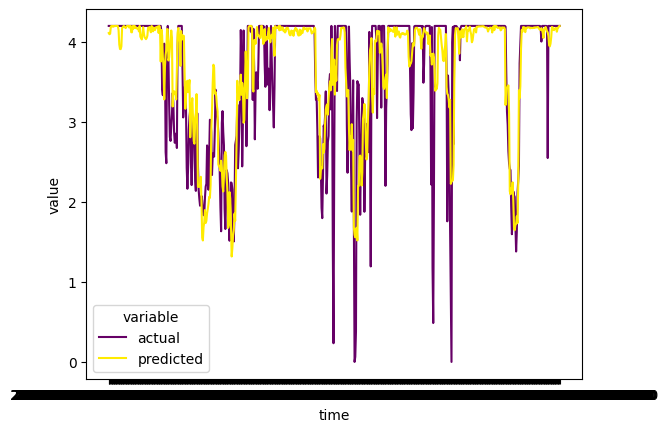

In [31]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_rfr_rescaled)

In [32]:
ev.get_eval_metrics(y_test_rescaled, y_pred_rfr_rescaled)

{'mae': 0.30949353044224726,
 'mse': 0.2915558143383889,
 'rmse': 0.5399590858003863,
 'mape': 26910414156550.477,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Endogenous Random Forest Regressor

In [33]:
# Drop exogenous variables
x_train_pure = x_train.drop(columns=['bf15_1h_lag0'])
x_test_pure = x_test.drop(columns=['bf15_1h_lag0'])

**Grid Search**

In [34]:
# Instantiate Grid Search Object
purerfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [35]:
purerfr_gridsearch.fit(x_train_pure, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [36]:
# Output Results
print(f"Best Parameters: {purerfr_gridsearch.best_params_}")
print(f"Best Score: {purerfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': 64, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Best Score: -0.012212279294922907


**RFR Model**

In [37]:
# Define hyperparameters
pure_params = {'max_depth': 64, 
               'min_samples_leaf': 8, 
               'min_samples_split': 4, 
               'n_estimators': 200}

In [38]:
# Parameterize model
pure_forest = RandomForestRegressor(**purerfr_gridsearch.best_params_)

In [39]:
# Train model
trained_pureforest = pure_forest.fit(x_train_pure, y_train)

In [40]:
# Predict inlet1
ypred_purerfr = trained_pureforest.predict(x_test_pure)

In [41]:
# Rescale predictions
y_pred_purerfr_rescaled = inverse_transform_minmax(df_scaled=ypred_purerfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

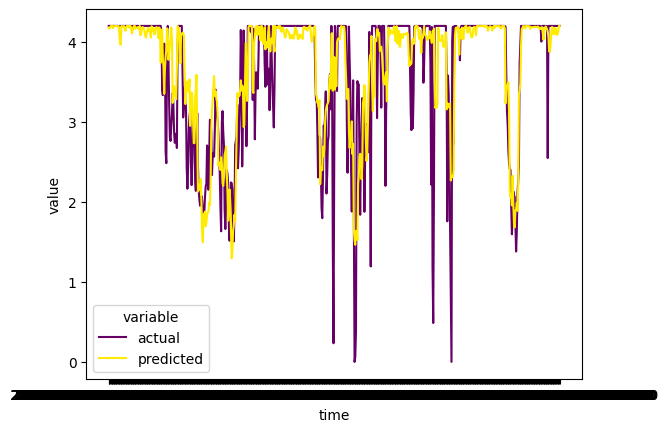

In [42]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_purerfr_rescaled)

In [43]:
ev.get_eval_metrics(y_test_rescaled, y_pred_purerfr_rescaled)

{'mae': 0.3128281884662668,
 'mse': 0.303496307127357,
 'rmse': 0.5509049892017288,
 'mape': 26909162378918.418,
 'non-na%': 1.0,
 'n_actual_obs': 643,
 'n_pred_nas': 0}

#### Linear Regression

In [44]:
linreg = LinearRegression()

In [45]:
trained_reg = linreg.fit(x_train, y_train)

In [46]:
ypred_linreg = trained_reg.predict(x_test)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
ypred_linreg_rescaled = inverse_transform_minmax(df_scaled=ypred_linreg, str_model='inlet1_ens', attributes='ytest')

In [ ]:
ev.get_act_vs_pred_plot(y_test_rescaled, ypred_linreg_rescaled)

In [ ]:
ev.get_eval_metrics(y_test_rescaled, ypred_linreg_rescaled)